# Imports

In [30]:
import numpy as np
import cv2
import glob
import itertools
import time
import pickle

from scipy.ndimage.measurements import label

from tensorflow.contrib.learn.python import learn as learn
from skimage import color, exposure
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import LinearSVC as SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('fivethirtyeight')

filepath = '../../p5_vehicle_detection/'
rand_state = 42

# Functions

## Bounding Box

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):

    # make a copy of the image
    draw_img = np.copy(img)

    # draw each bounding box
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    
    # return the image copy with boxes drawn
    return draw_img

## Labeled Boxes

In [3]:
def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
    
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # Return the image
    return img

## Search Windows

In [4]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       hist_range=hist_range,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    # Return windows for positive detections
    return on_windows

## Sliding Windows

In [5]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # TODO: vectorize this step
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Template Matching

In [6]:
def find_matches(img, template_list):

    # Define an empty list to take bbox coords
    bbox_list = []

    # match method
    method = cv2.TM_CCOEFF
    
    # Iterate through template list
    for template in template_list:
        timg = mpimg.imread(template)
        w, h = timg.shape[0], timg.shape[1]
        
        # Apply template Matching
        res = cv2.matchTemplate(img, timg, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        
        # get bbox
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        bbox_list.append((top_left, bottom_right))
        
    # Return the list of bounding boxes
    return bbox_list

## Color Histograms

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256)):

    # Compute the histogram of the RGB channels separately
    hists = []
    for channel in range(img.shape[2]):
        hists.append(np.histogram(img[: , :, channel], bins=nbins, range=bins_range))

    # Generating bin centers
    bin_edges = hists[0][1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1]) / 2

    # Concatenate the histograms into a single feature vector
    all_hist = [h[0] for h in hists]
    hist_features = list(itertools.chain.from_iterable(all_hist))

    # Return the individual histograms, bin_centers and feature vector
    return hists, bin_centers, hist_features

## Color Space Plot

In [8]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax

## Spatial Binning

In [9]:
def bin_spatial(img, size=(32, 32)):

    # Use cv2.resize().ravel() to create the feature vector
    return cv2.resize(img, size).ravel() 

## Heatmap

In [10]:
def add_heat(heatmap, bbox_list):

    # Iterate through list of bboxes
    for box in bbox_list:
    
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

## Heatmap Threshold

In [11]:
def apply_threshold(heatmap, threshold):
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

## Single Image Feature Extractor

In [12]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, hist_range=(0,256),
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    

    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    # Compute histogram features if flag is set
    if hist_feat == True:
        _, _, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        img_features.append(hist_features)
    
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)

## Whole Image Feature Extractor

In [13]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # iterate over files
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        img = mpimg.imread(file)
        
        # Convert image to new color space (if specified)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img) 
        
        # spatial features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        # color features
        if hist_feat == True:
            _, _, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
            
        # hog features
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orient, pix_per_cell, cell_per_block, 
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        
        # append features
        features.append(np.concatenate(file_features))
        
    # return feature vector
    return features

## Data Profiling

In [14]:
def data_look(car_list, notcar_list):

    # empty dict
    data_dict = {}

    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    
    # Return data_dict
    return data_dict

## Histogram of Gradients (HOG)

In [15]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Experimentation

## Make Bounding Boxes

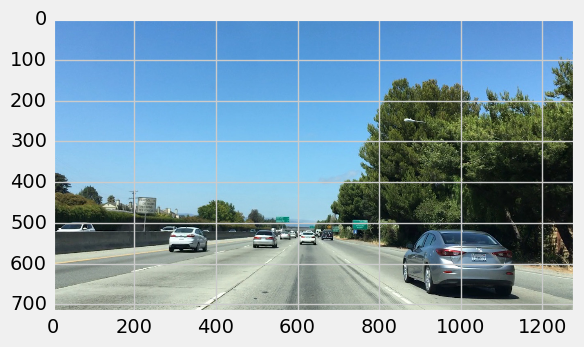

In [20]:
# load image
raw = mpimg.imread(filepath+'/test_images/bbox-example-image.jpg');

# view image
plt.imshow(raw);

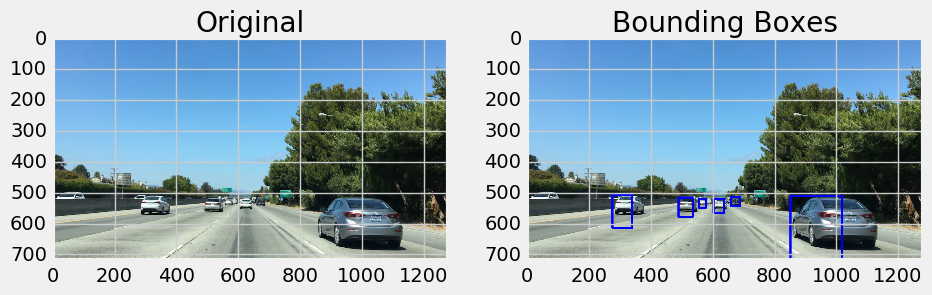

In [21]:
# get bonding boxes from template matching
bboxes = find_matches(raw, templist)

# draw bounding boxes
bboxed = draw_boxes(raw, bboxes)

# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(raw)
ax1.set_title('Original')
ax2.imshow(bboxed)
ax2.set_title('Bounding Boxes')
write_name = filepath+'/output_images/bboxed.jpg'
plt.savefig(write_name)

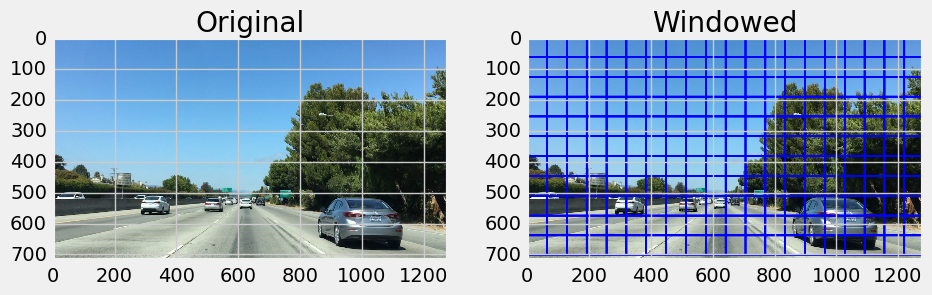

In [26]:
windows = slide_window(raw, x_start_stop=[None, None], y_start_stop=[None, None],
                       xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
windowed = draw_boxes(raw, windows, color=(0, 0, 255), thick=6)

# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(raw)
ax1.set_title('Original')
ax2.imshow(windowed)
ax2.set_title('Windowed')
write_name = filepath+'/output_images/windowed.jpg'
plt.savefig(write_name)

## Make Color Histograms

In [ ]:
# image templates
templist = sorted(glob.glob(filepath+'test_images/cutout*.jpg'))

# get templates color histogram
for template in templist:
    image = mpimg.imread(template)
    hists, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

    # Plot a figure with all three bar charts
    subplots = 101 + len(hists)*10
    fig = plt.figure(figsize=(12,3))
    for i, hist in enumerate(hists):
        plt.subplot(subplots)
        plt.bar(bincen, hist[0], width=4.0)
        plt.xlim(0, 260)
        plt.title('Channel '+str(i))
        subplots += 1
    fig.tight_layout()

## Make 3D Color Plots

In [ ]:
# load image
img = mpimg.imread(filepath+'/test_images/bbox-example-image.jpg');

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img,
                       (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)),
                       interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# RGB Plot
plot3d(img_small_RGB, img_small_rgb)#, axis_limits=[(0, 1), (0, 1), (0, 1)])
plt.show()

In [ ]:
# HSV Plot
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))#, axis_limits=[(0, 1), (0, 1), (0, 1)])
plt.show()

## Make Spatially Binned

In [ ]:
# image templates
templist = sorted(glob.glob(filepath+'test_images/cutout*.jpg'))

for template in templist:
    image = mpimg.imread(template)
    print('Original: {}'.format(image.shape))
    feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))
    print('1D-vector: {}\n'.format(feature_vec.shape))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features');

# Run Classifier

## Load Classifier Training Data

In [16]:
# images are divided up into vehicles and non-vehicles
images = sorted(glob.glob('../../data/vehicles_notvehicles/*.png'))
cars = []
notcars = []

# loop over images
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# build dict of data profile
data_info = data_look(cars, notcars)
print('Cars: {}'.format(data_info["n_cars"]))
print('Non-cars: {}'.format(data_info["n_notcars"]))
print('Image shape: {}'.format(data_info["image_shape"]))
print('Data type: {}'.format(data_info["data_type"]))

Cars: 5966
Non-cars: 8968
Image shape: (64, 64, 3)
Data type: float32


## Train Image Classifier

In [17]:
# general params
color_space = 'RGB'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_feat = True
hist_feat = True
hog_feat = True

In [18]:
# car features
car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                hist_range=hist_range, orient=orient,
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

# non-car features
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)

# check for outputs
if len(car_features) > 0:
    print('Found {} cars with {} features each.'.format(len(car_features), len(car_features[0])))
else:
    raise ValueError('The car feature vector is empty! Zero length')

Found 5966 cars with 4932 features each.


In [20]:
# creat vector of labels
y = np.hstack((np.ones(len(car_features)),
               np.zeros(len(notcar_features))))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

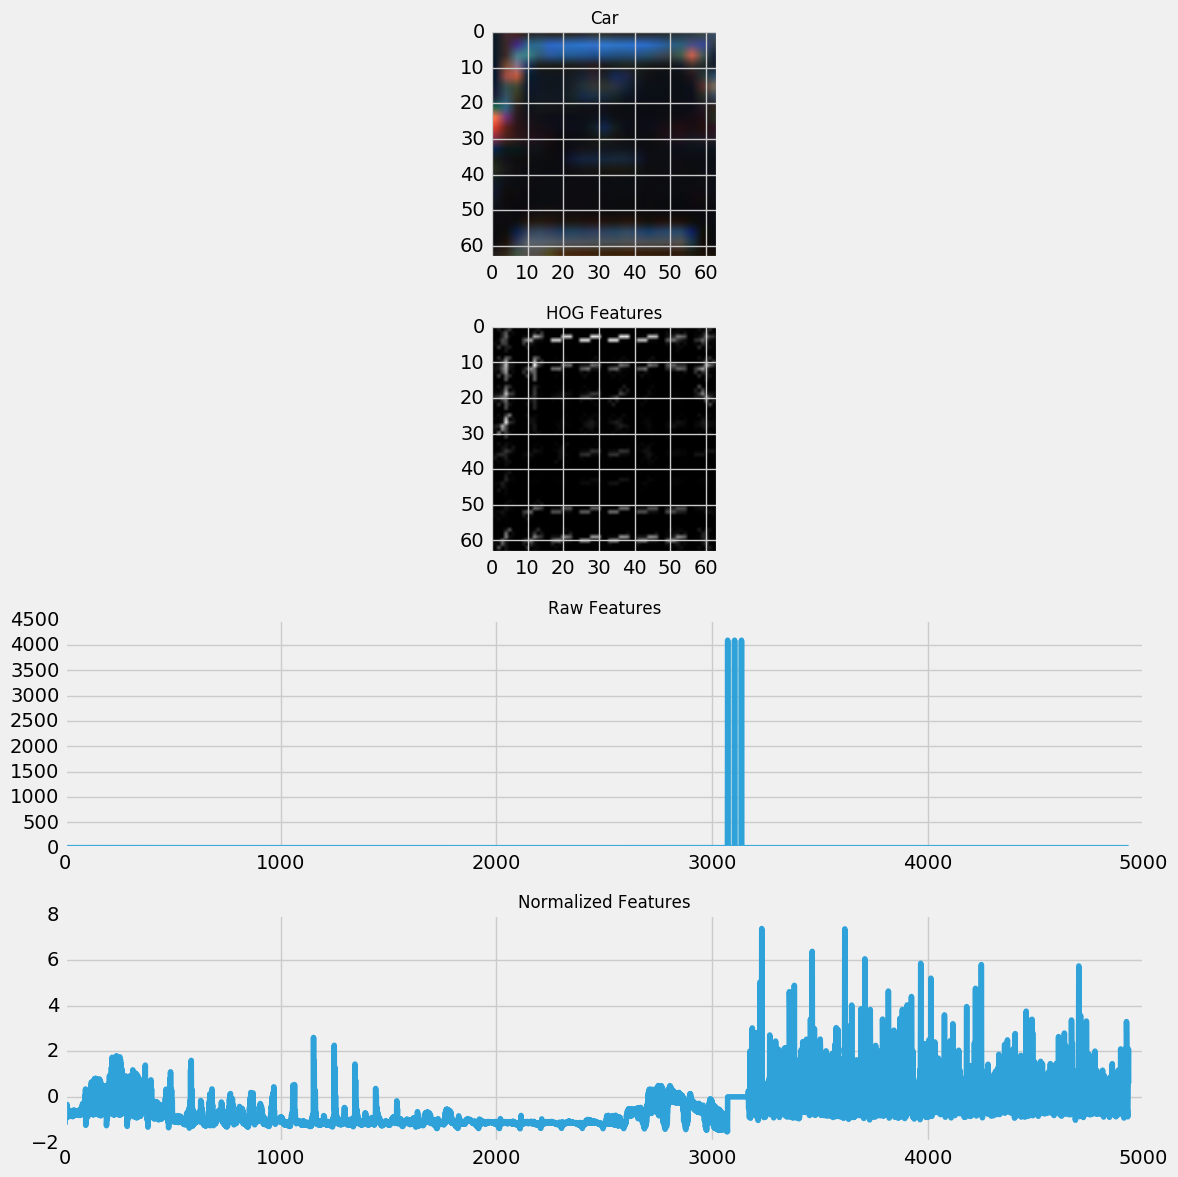

In [21]:
# Generate a random index to look at a car image
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# grayscale the images        
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
noncar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
_, hog_image = get_hog_features(car_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot results
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
ax1.imshow(car_image)
ax1.set_title('Car', fontsize=12)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Features', fontsize=12)
ax3.plot(X[car_ind])
ax3.set_title('Raw Features', fontsize=12)
ax4.plot(scaled_X[car_ind])
ax4.set_title('Normalized Features', fontsize=12)
f.tight_layout()
write_name = filepath+'output_images/car_features'+'.jpg'
plt.savefig(write_name)

In [23]:
# create the classifier
clf = SVC()
#clf = DTC()
#clf = RFC()

# train classifier
clf.fit(X_train, y_train)

# Prepackaged DNN on TF?
#feature_columns = learn.infer_real_valued_columns_from_input(X_train)
#clf = learn.DNNClassifier(hidden_units=[10, 20, 10], n_classes=2, feature_columns=feature_columns)
#clf.fit(X_train, y_train, steps=200, batch_size=32)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [24]:
# Scoring
print('Test Accuracy: {:.2f}%'.format(100.0 * clf.score(X_test, y_test)))

# Subtest
n_predict = 10
print('Model predicts: {}'.format(clf.predict(X_test[0:n_predict])))
print('With {} labels: {}'.format(n_predict, y_test[0:n_predict]))

Test Accuracy: 98.96%
Model predicts: [ 1.  1.  1.  1.  0.  1.  0.  0.  0.  0.]
With 10 labels: [ 1.  1.  1.  1.  0.  1.  0.  0.  0.  0.]


In [25]:
# Save model and its params
dist_pickle = {}
dist_pickle["color_space"] = color_space
dist_pickle["clf"] = clf
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["hist_range"] = hist_range
pickle.dump(dist_pickle, open( "clf_pickle.p", "wb" ) )

## Apply Classifier to Sliding Window

In [26]:
# general params
y_start_stop = [300, 700] # Min and max in y to search in slide_window()
xy_window = (64, 64)
xy_overlap = (0.75, 0.75)

# load data
raw_image = mpimg.imread(filepath+'/test_images/test4.jpg');
draw_image = np.copy(raw_image)
image = raw_image.astype(np.float32)/255  # trained on PNG but testing on JPG

# create windows
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                       xy_window=xy_window, xy_overlap=xy_overlap)
print('Created {} windows'.format(len(windows)))

# apply windows and find matches
hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                             spatial_size=spatial_size, hist_bins=hist_bins, 
                             orient=orient, pix_per_cell=pix_per_cell, 
                             cell_per_block=cell_per_block, 
                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
                             hist_feat=hist_feat, hog_feat=hog_feat)                       
print('Found {} possible cars'.format(len(hot_windows)))
with open('bbox_pickle.p','wb') as f:
    pickle.dump(hot_windows, f)

Created 1694 windows
Found 28 possible cars


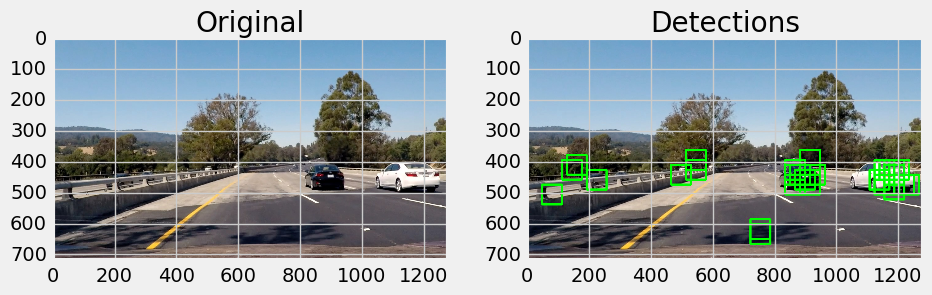

In [27]:
# draw boxes over cars
window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                    

# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(image)
ax1.set_title('Original')
ax2.imshow(window_img)
ax2.set_title('Detections')
write_name = filepath+'/output_images/sliding_windows.jpg'
plt.savefig(write_name)

In [28]:
# create template heatmap
heat = np.zeros_like(raw_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(raw_image), labels)

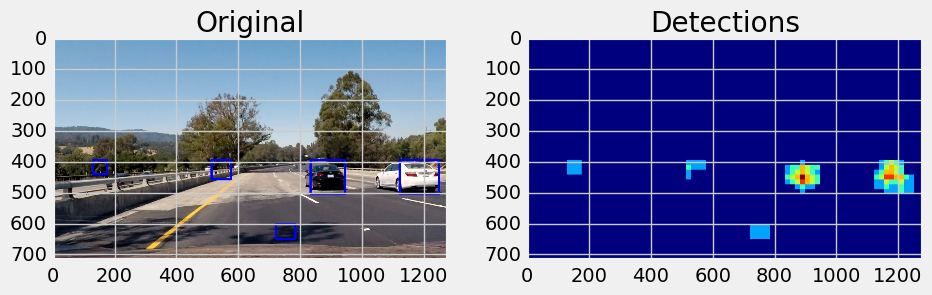

In [29]:
# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(draw_img)
ax1.set_title('Original')
ax2.imshow(heatmap)
ax2.set_title('Detections')
write_name = filepath+'/output_images/heatmap.jpg'
plt.savefig(write_name)

# Video Pipeline

In [ ]:
bboxes_list = []

video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "project_output.mp4"
%time project_clip.write_videofile(video_output, audio=False)

print("Bounding boxes: ", bboxes_list)

In [ ]:
output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline)
output_clip.write_videofile(output, audio=False)

In [ ]:
%%HTML
<video width="960" height="540" controls>
  <source src="project_output.mp4" type="video/mp4">
</video>